In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [12]:
state = AgentState()

In [16]:
state['test']=(SystemMessage(content='hello world'))

In [ ]:
state['test'].

AttributeError: 'SystemMessage' object has no attribute 'tool_calls'

In [ ]:
class Agent:

    def __init__(self, model_query, model_filter, tools, top_k):
        self.system_query = "Decompose the following query into simpler parts"
        graph = StateGraph(AgentState)
        graph.add_node("llm_query", self.call_openai_query)
        graph.add_node("action", self.take_action)
        graph.add_node("llm_filter", self.call_openai_filter)
        graph.add_edge("llm_query", "action")
        graph.add_edge("action", "llm_filter")
        graph.set_entry_point("llm_query")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model_query = model_query.bind_tools(tools)
        self.model_filter = model_filter.bind_tools(tools)
        self.top_k = top_k

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai_query(self, state: AgentState):
        messages = state['messages']
        messages = [SystemMessage(content=self.system_query)] + messages
        message = self.model_query.invoke(messages)
        return {'messages': [message]}
    
    def call_openai_filter(self, state: AgentState):
        query = state['messages'][0].content
        system_filter = f"Filter the following results based on the given query:{query}."

        messages = state['messages'][-1]
        messages = [SystemMessage(content=system_filter)] + messages
        message = self.model_filter.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:
                print("\n ....bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("To the filter model!")
        return {'messages': results}

In [10]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

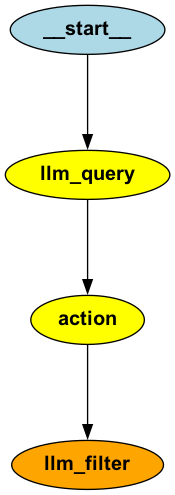

In [11]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [14]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_jLrIePUkgJRW2ZqLGzo2Oc7H', 'type': 'tool_call'}
Back to the model!


In [15]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jLrIePUkgJRW2ZqLGzo2Oc7H', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c45464e3-7091-46ac-b9e2-16d79e316f00-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_jLrIePUkgJRW2ZqLGzo2Oc7H', 'type': 'tool_call'}], usage_metadata=

In [16]:
result['messages'][-1].content

'The current weather in San Francisco is overcast with a temperature of 55.9°F (13.3°C). The wind speed is 4.7 mph (7.6 kph) coming from the SSW direction. The humidity is at 55%, and the visibility is 9.0 miles.'

In [17]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_raSSECItsjzy2bsduQkfoWnV', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_FcpsCbZmK1GCZmOOSWoC27Ez', 'type': 'tool_call'}
Back to the model!


In [18]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_GGkgepw53fS2g86pTPXHqL5g', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_DmR8DGgMPqh9Rci5bewRqslC', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_4MRZJp96QTWIB6DLIP7S4w6X', 'type': 'tool_call'}
Back to the model!


In [19]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**

   The Kansas City Chiefs won the Super Bowl in 2024.

2. **In what state is the winning team's headquarters located?**

   The Kansas City Chiefs' headquarters is located in Missouri.

3. **What is the GDP of that state?**

   While the specific GDP for Missouri in 2024 is not readily available from the current search results, you can refer to the U.S. Bureau of Economic Analysis or similar economic reports for the most recent and precise figures. The Missouri Economic and Workforce Report can also provide insights into the state's economic status.
